In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import missingno as mno

In [2]:
df = pd.read_csv('../data/data_clean.csv', sep=',', encoding='latin-1')
df = df.drop(columns=['PAQ706'])
df = df.drop(columns = ['CDQ001', 'CDQ010', 'DIQ070', 'DBD100', 'highLDL'])

#variable choice to create dataset for missignness simulation

cols = ['SEQN','RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
                 'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
                 'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
                 'PAQ650', 'PAQ665','PAD680', 'PAQ710', 'DR1TKCAL'] 

# cols = ['SEQN','RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
#                  'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
#                  'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
#                  'PAQ650', 'PAQ665', 'PAQ710'] 

# cols = ['SEQN', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
#                  'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
#                  'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
#                  'PAQ650', 'PAQ665', 'PAQ710'] 

df_nonmiss = df[cols] 

np_nonmiss = df_nonmiss.to_numpy(copy=True, na_value=np.nan) # Convert dataframe to numpy array 

np_nonmiss = np_nonmiss[~np.isnan(np_nonmiss).any(axis=1), :] # delete rows with any missing values

seqn = np_nonmiss[:, 0] #record seqn for rows in df_nonmiss
np_nonmiss = np_nonmiss[:, 1:18] #remove seqn
print(np.shape(np_nonmiss)) 

cols = cols[1:]

(4756, 17)


In [3]:
p = 0.1
#MCAR

MCAR_data = np.copy(np_nonmiss) #init data

MCAR_missing_indices = np.random.choice( # randomly select values from length ie flat array 
    len(np_nonmiss.flatten()), 
    size=int(len(np_nonmiss.flatten())*p)) 
MCAR_data.flat[MCAR_missing_indices] = np.nan

MCAR_data.shape

(4756, 17)

In [4]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [5]:
def run(data, cols, method='stochastic'): 
    df = pd.DataFrame(data, columns=cols)
    mno.matrix(df, figsize = (20, 6))
    missing_columns = cols 
    
    for feature in missing_columns:
        df[feature + '_imp'] = df[feature]
        df = random_imputation(df, feature) 


    if method == 'deterministic': 
        deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])
        for feature in missing_columns:

            deter_data["Det" + feature] = df[feature + "_imp"]
            parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

            #Create a Linear Regression model to estimate the missing data
            model = linear_model.LinearRegression()
            model.fit(X = df[parameters], y = df[feature + '_imp'])

            #observe that I preserve the index of the missing data from the original dataframe
            deter_data.loc[df[feature].isnull(), "Det" + feature] = \
                            model.predict(df[parameters])[df[feature].isnull()]

#         mno.matrix(deter_data, figsize = (20,5))

        sns.set()
        fig, axes = plt.subplots(nrows = 2, ncols = 2)
        fig.set_size_inches(8, 8)

        for index, variable in enumerate([cols[0], cols[1]]):
            sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
            sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')

            sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                        ax = axes[index, 1])

        plt.tight_layout() 
        return deter_data 

    if method == 'stochastic': 
        random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

        for feature in missing_columns:

            random_data["Ran" + feature] = df[feature + '_imp']
            parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

            model = linear_model.LinearRegression()
            model.fit(X = df[parameters], y = df[feature + '_imp'])

            #Standard Error of the regression estimates is equal to std() of the errors of each estimates
            predict = model.predict(df[parameters])
            std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()

            #observe that I preserve the index of the missing data from the original dataframe
            random_predict = np.random.normal(size = df[feature].shape[0], 
                                              loc = predict, 
                                              scale = std_error)
            random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = \
                                    random_predict[(df[feature].isnull()) & (random_predict > 0)] 
            
        sns.set()
        fig, axes = plt.subplots(nrows = 2, ncols = 2)
        fig.set_size_inches(8, 8)

        for index, variable in enumerate([cols[0], cols[2]]):
            sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
            sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
            axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')

            sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                        ax = axes[index, 1])

        plt.tight_layout() 
        return random_data

/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


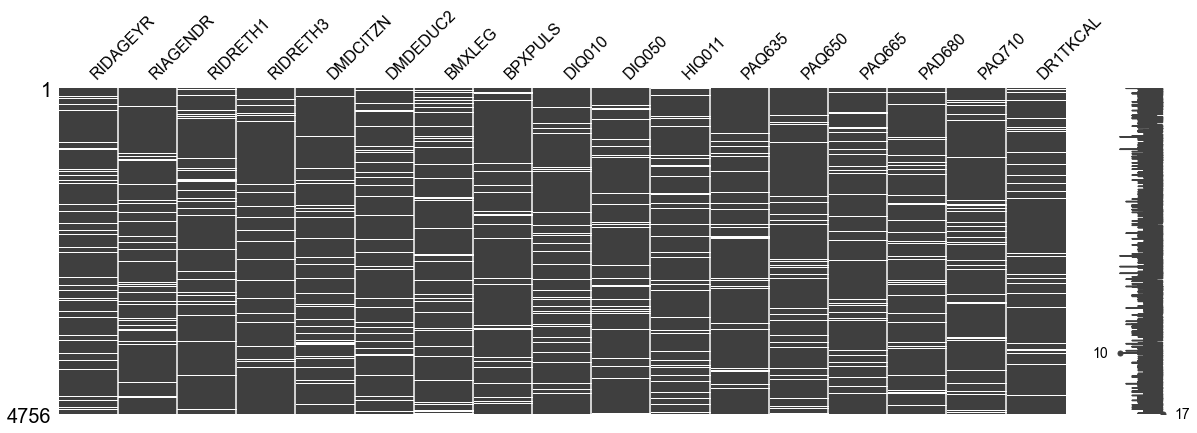

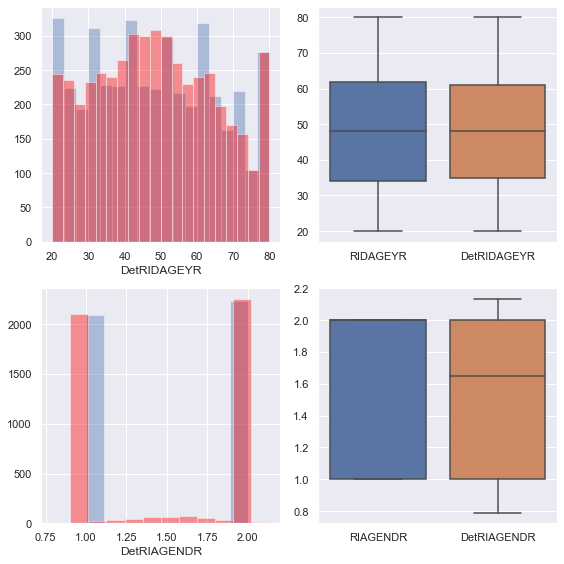

In [6]:
deter_data = run(MCAR_data, cols, method='deterministic') 

In [7]:
print(mean_squared_error(np_nonmiss.flat[MCAR_missing_indices], deter_data.to_numpy().flat[MCAR_missing_indices]))

66836.58904564363


In [8]:
np_nonmiss_df = pd.DataFrame(np_nonmiss, columns=deter_data.columns)
for col in deter_data.columns: 
    print(col, '\t', mean_squared_error(np_nonmiss_df[col].to_numpy(), deter_data[col].to_numpy()))

DetRIDAGEYR 	 22.29437820694007
DetRIAGENDR 	 0.016852185743502942
DetRIDRETH1 	 0.022936241422153305
DetRIDRETH3 	 0.048562516009777554
DetDMDCITZN 	 0.011015057199696742
DetDMDEDUC2 	 0.12411956860702665
DetBMXLEG 	 0.8241763974855992
DetBPXPULS 	 0.0006579826029353602
DetDIQ010 	 0.01306726440812606
DetDIQ050 	 0.0031150818526868504
DetHIQ011 	 0.027408800125273032
DetPAQ635 	 0.017716718566843422
DetPAQ650 	 0.015204110587854189
DetPAQ665 	 0.0229735743121056
DetPAD680 	 3302.8890181953066
DetPAQ710 	 0.29094999609371197
DetDR1TKCAL 	 106091.87119203237


/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


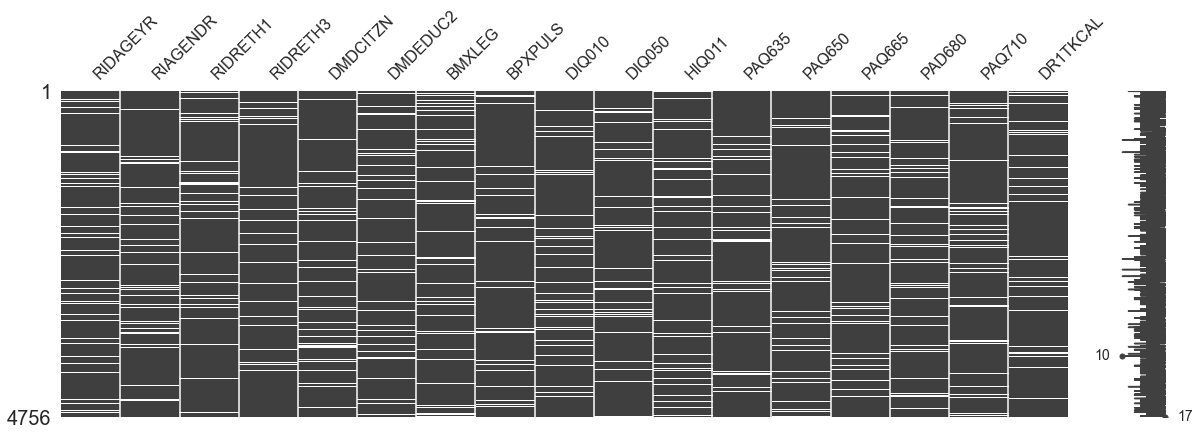

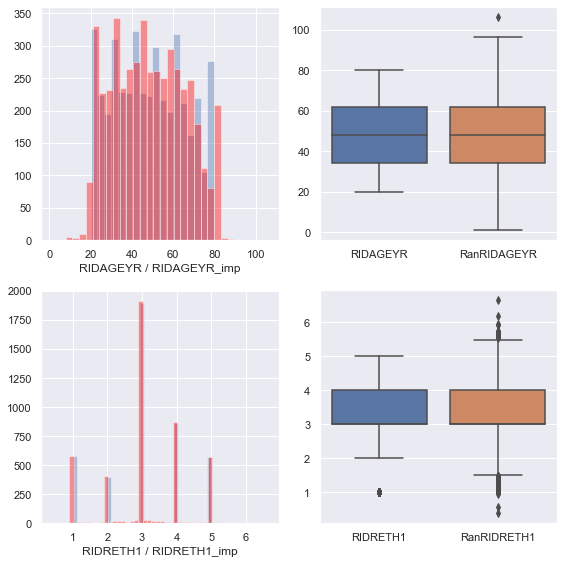

In [9]:
random_data = run(MCAR_data, cols, method='stochastic') 

In [10]:
print(mean_squared_error(np_nonmiss.flat[MCAR_missing_indices], random_data.to_numpy().flat[MCAR_missing_indices])) 

120096.88225697548


In [11]:
np_nonmiss_df = pd.DataFrame(np_nonmiss, columns=random_data.columns)
for col in random_data.columns: 
    print(col, '\t', mean_squared_error(np_nonmiss_df[col].to_numpy(), random_data[col].to_numpy()))

RanRIDAGEYR 	 45.467433929142935
RanRIAGENDR 	 0.030477638990101575
RanRIDRETH1 	 0.052058067002896974
RanRIDRETH3 	 0.08216965332525072
RanDMDCITZN 	 0.01936161559944259
RanDMDEDUC2 	 0.241745683874943
RanBMXLEG 	 1.8319189258631448
RanBPXPULS 	 0.002318744440162132
RanDIQ010 	 0.025069388989003287
RanDIQ050 	 0.006711915096375815
RanHIQ011 	 0.04850214487766484
RanPAQ635 	 0.038171727370150565
RanPAQ650 	 0.03057945769017528
RanPAQ665 	 0.04360584979716205
RanPAD680 	 7296.451318553706
RanPAQ710 	 0.5077287442689941
RanDR1TKCAL 	 188244.3170489784
